In [1]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
path = '../data/processed_price_paid/price_paid_2024.parquet'
ONSPD_path = "../data/ocod_history_processed/OCOD_FULL_2017_03.parquet"
figures_folder = Path('../figures')


ModuleNotFoundError: No module named 'tqdm'

In [3]:
!pip install openpyxl

# Get MSOA dwelling counts from 2021 census

https://statistics.ukdataservice.ac.uk/dataset/england-and-wales-census-2021-rm205-dwelling-type/resource/f7cde7e0-5c9b-4091-bfb6-b34db820f30e

In [4]:
msoa_dwelling = pd.read_excel('https://ukds-ckan.s3.eu-west-1.amazonaws.com/2021/ONS/dwelling-type/RM205-Dwelling-Type-2021-msoa-ONS.xlsx',
).rename(columns = {'Middle layer Super Output Areas Code':'msoa11cd', 'Observation':'dwellings'})
msoa_dwelling = msoa_dwelling.groupby('msoa11cd')['dwellings'].sum().reset_index()

<Axes: xlabel='dwellings', ylabel='Count'>

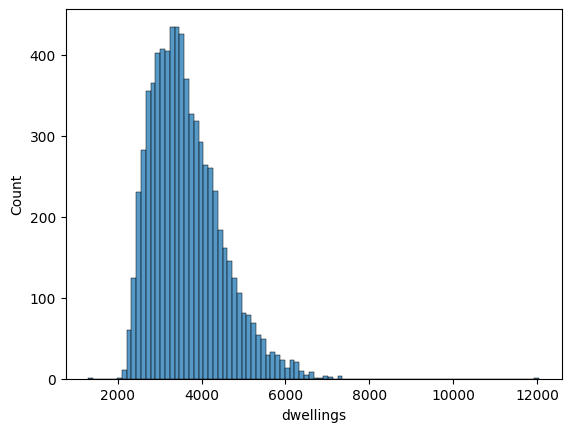

In [54]:
sns.histplot(msoa_dwelling, x = 'dwellings')

In [6]:
test = pd.read_csv('../data/ocod_history/OCOD_FULL_2022_02.zip')


/tmp/ipykernel_174004/271194206.py:1: DtypeWarning: Columns (24,28,30,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.


In [7]:
test.shape

(94091, 39)

In [8]:
def create_time_series_by_groups(grouping_vars=None):
    """
    Create time series with optional grouping variables
    
    Args:
        grouping_vars (list or None): List of column names to group by (e.g., ['region'])
    """
    ocod_path = Path('../data/ocod_history_processed')
    price_paid_path = Path('../data/price_paid_msoa_averages')

    # List to store results
    results = []

    # Get all parquet files from ocod directory
    ocod_files = list(ocod_path.glob('*.parquet'))

    for ocod_file in tqdm(ocod_files):
        # Extract year and month from filename
        filename_parts = ocod_file.stem.split('_')
        year = int(filename_parts[-2])
        month = int(filename_parts[-1])
        
        # Create corresponding price_paid filename
        price_paid_file = price_paid_path / f'price_paid_{year}_{month:02d}.parquet'
        
        # Check if corresponding price_paid file exists
        if not price_paid_file.exists():
            print(f"Warning: {price_paid_file} not found, skipping...")
            continue
        
        try:
            # Read the data
            ocod_df = pd.read_parquet(ocod_file)
            price_paid_df = pd.read_parquet(price_paid_file)
            
            # Filter for residential properties
            ocod_residential = ocod_df.loc[ocod_df['class2']=='residential'].copy()
            
            # Skip if no residential properties
            if ocod_residential.empty:
                print(f"Warning: No residential properties for {year}-{month:02d}, skipping...")
                continue
            
            # Determine grouping columns
            if grouping_vars is None:
                group_cols = ['msoa11cd']
            else:
                group_cols = ['msoa11cd'] + grouping_vars
            
            # Group and count
            ocod_grouped = ocod_residential.groupby(group_cols).size().reset_index().rename(columns={0:'counts'})
            
            # Merge with price data
            df = price_paid_df.merge(ocod_grouped, on='msoa11cd')
            
            # Skip if no data after merge
            if df.empty:
                print(f"Warning: No data after merge for {year}-{month:02d}, skipping...")
                continue
            
            # Create date as first day of the month
            date = datetime(year, month, 1)
            
            # Group by additional variables if specified
            if grouping_vars is None:
                # No additional grouping - aggregate all data
                # Weighted averages (by offshore property counts)
                ocod_weighted_mean = np.average(df['price_mean'], weights=df['counts'])
                ocod_weighted_median = np.average(df['price_median'], weights=df['counts'])
                
                # Unweighted averages (treating all MSOAs equally)
                ocod_unweighted_mean = df['price_mean'].mean()
                ocod_unweighted_median = df['price_median'].mean()
                
                # Calculate ratios
                weighted_unweighted_mean_ratio = ocod_weighted_mean / ocod_unweighted_mean
                weighted_unweighted_median_ratio = ocod_weighted_median / ocod_unweighted_median
                
                # Calculate total counts and total value
                total_counts = df['counts'].sum()
                total_value_mean = total_counts * ocod_weighted_mean
                total_value_median = total_counts * ocod_weighted_median
                
                results.append({
                    'date': date,
                    'year': year,
                    'month': month,
                    'ocod_weighted_mean': int(ocod_weighted_mean),
                    'ocod_weighted_median': int(ocod_weighted_median),
                    'ocod_unweighted_mean': int(ocod_unweighted_mean),
                    'ocod_unweighted_median': int(ocod_unweighted_median),
                    'weighted_unweighted_mean_ratio': weighted_unweighted_mean_ratio,
                    'weighted_unweighted_median_ratio': weighted_unweighted_median_ratio,
                    'total_counts': int(total_counts),
                    'total_value_mean': int(total_value_mean),
                    'total_value_median': int(total_value_median)
                })
            else:
                # Group by additional variables
                for group_values, group_df in df.groupby(grouping_vars):
                    if group_df.empty:
                        continue
                    
                    # Weighted averages (by offshore property counts)
                    ocod_weighted_mean = np.average(group_df['price_mean'], weights=group_df['counts'])
                    ocod_weighted_median = np.average(group_df['price_median'], weights=group_df['counts'])
                    
                    # Unweighted averages (treating all MSOAs equally)
                    ocod_unweighted_mean = group_df['price_mean'].mean()
                    ocod_unweighted_median = group_df['price_median'].mean()
                    
                    # Calculate ratios
                    weighted_unweighted_mean_ratio = ocod_weighted_mean / ocod_unweighted_mean
                    weighted_unweighted_median_ratio = ocod_weighted_median / ocod_unweighted_median
                    
                    # Calculate total counts and total value for this group
                    total_counts = group_df['counts'].sum()
                    total_value_mean = total_counts * ocod_weighted_mean
                    total_value_median = total_counts * ocod_weighted_median
                    
                    # Create result dictionary
                    result = {
                        'date': date,
                        'year': year,
                        'month': month,
                        'ocod_weighted_mean': int(ocod_weighted_mean),
                        'ocod_weighted_median': int(ocod_weighted_median),
                        'ocod_unweighted_mean': int(ocod_unweighted_mean),
                        'ocod_unweighted_median': int(ocod_unweighted_median),
                        'weighted_unweighted_mean_ratio': weighted_unweighted_mean_ratio,
                        'weighted_unweighted_median_ratio': weighted_unweighted_median_ratio,
                        'total_counts': int(total_counts),
                        'total_value_mean': int(total_value_mean),
                        'total_value_median': int(total_value_median)
                    }
                    
                    # Add grouping variables to result
                    if isinstance(group_values, tuple):
                        for i, var in enumerate(grouping_vars):
                            result[var] = group_values[i]
                    else:
                        result[grouping_vars[0]] = group_values
                    
                    results.append(result)
                
        except Exception as e:
            print(f"Error processing {ocod_file.name}: {str(e)}")
            continue

    # Create DataFrame from results
    time_series_df = pd.DataFrame(results)
    
    if not time_series_df.empty:
        # Sort by date and grouping variables for proper time series
        sort_cols = ['date']
        if grouping_vars:
            sort_cols.extend(grouping_vars)
        time_series_df = time_series_df.sort_values(sort_cols).reset_index(drop=True)
    
    return time_series_df

In [41]:
def create_time_series_by_groups(msoa_dwellings, grouping_vars=None):
    """
    Create time series with optional grouping variables and dwelling data
    
    Args:
        msoa_dwellings (pd.DataFrame): DataFrame with MSOA dwelling counts
        grouping_vars (list or None): List of column names to group by (e.g., ['region'])
    
    Returns:
        pandas.DataFrame: Time series data with aggregated statistics
    """
    ocod_path = Path('../data/ocod_history_processed')
    price_paid_path = Path('../data/price_paid_msoa_averages')
    results = []

    # Iterate through OCOD files
    for ocod_file in tqdm(list(ocod_path.glob('*.parquet'))):
        year, month = _extract_year_month(ocod_file)
        price_paid_file = price_paid_path / f'price_paid_{year}_{month:02d}.parquet'
        
        # Skip if price paid file is missing
        if not price_paid_file.exists():
            print(f"Warning: {price_paid_file} not found, skipping...")
            continue
        
        try:
            ocod_df, price_paid_df = _load_and_preprocess_data(ocod_file, price_paid_file)
            
            # Skip if no residential properties
            if ocod_df.empty:
                print(f"Warning: No residential properties for {year}-{month:02d}, skipping...")
                continue
            
            # Perform aggregation
            time_series_data = _aggregate_time_series_data(
                ocod_df, 
                price_paid_df, 
                msoa_dwellings,
                year, 
                month, 
                grouping_vars
            )
            
            results.extend(time_series_data)
            
        except Exception as e:
            print(f"Error processing {ocod_file.name}: {str(e)}")
            continue

    # Create and sort DataFrame
    return _create_final_dataframe(results, grouping_vars)

def _extract_year_month(ocod_file):
    """Extract year and month from filename"""
    filename_parts = ocod_file.stem.split('_')
    return int(filename_parts[-2]), int(filename_parts[-1])

def _load_and_preprocess_data(ocod_file, price_paid_file):
    """Load and preprocess OCOD and price paid data"""
    ocod_df = pd.read_parquet(ocod_file)
    price_paid_df = pd.read_parquet(price_paid_file)
    
    # Filter for residential properties
    ocod_residential = ocod_df.loc[ocod_df['class2'] == 'residential'].copy()
    
    return ocod_residential, price_paid_df

def _aggregate_time_series_data(ocod_df, price_paid_df, msoa_dwellings, year, month, grouping_vars):
    """Aggregate time series data with optional grouping"""
    # Determine grouping columns
    group_cols = ['msoa11cd'] + (grouping_vars or [])
    
    # Group and count offshore properties
    ocod_grouped = ocod_df.groupby(group_cols).size().reset_index(name='ocod_total_counts')
    
    # Merge with price data and dwelling data
    df = price_paid_df.merge(ocod_grouped, on='msoa11cd', how='right')
    df = df.merge(msoa_dwellings, on='msoa11cd', how='left')
    df['ocod_total_counts'] = df['ocod_total_counts'].fillna(0).astype(int)
    
    # Create date
    date = datetime(year, month, 1)
    
    # Perform aggregation based on grouping
    return _calculate_aggregations(df, date, year, month, grouping_vars)

def _calculate_aggregations(df, date, year, month, grouping_vars):
    """Calculate aggregation metrics"""
    def calculate_metrics(group_df):
        """Calculate metrics for a group"""
        # Fill NaN values with 0 for counts
        group_df['ocod_total_counts'] = group_df['ocod_total_counts'].fillna(0)
        group_df['dwellings'] = group_df['dwellings'].fillna(0)
        # Weighted by OCOD counts
        ocod_weighted_mean = np.average(group_df['price_mean'], weights=group_df['ocod_total_counts'])
        ocod_weighted_median = np.average(group_df['price_median'], weights=group_df['ocod_total_counts'])
        
        # Weighted by dwelling counts
        dwelling_weighted_mean = np.average(group_df['price_mean'], weights=group_df['dwellings'])
        dwelling_weighted_median = np.average(group_df['price_median'], weights=group_df['dwellings'])
        
        # Total counts and values
        total_ocod_counts = group_df['ocod_total_counts'].sum()
        total_dwelling_count = group_df['dwellings'].sum()
        
        total_value_ocod_mean = total_ocod_counts * ocod_weighted_mean
        total_value_dwelling_mean = total_dwelling_count * dwelling_weighted_mean
        
        # Fraction of total value
        fraction_of_total_value = total_value_ocod_mean / total_value_dwelling_mean if total_value_dwelling_mean > 0 else np.nan
        
        result = {
            'date': date,
            'year': year,
            'month': month,
            'ocod_mean': int(ocod_weighted_mean),
            'ocod_median': int(ocod_weighted_median),
            'dwelling_mean': int(dwelling_weighted_mean),
            'dwelling_median': int(dwelling_weighted_median),
            'ocod_ratio_mean': ocod_weighted_mean / dwelling_weighted_mean if dwelling_weighted_mean > 0 else np.nan,
            'ocod_total_counts': int(total_ocod_counts),
            'total_dwelling_count': int(total_dwelling_count),
            'total_value_ocod_mean': int(total_value_ocod_mean),
            'total_value_dwelling_mean': int(total_value_dwelling_mean),
            'fraction_of_total_value': fraction_of_total_value
        }
        
        # Add grouping variables if applicable
        if grouping_vars:
            for var in grouping_vars:
                result[var] = group_df[var].iloc[0]
        
        return result

    # If no grouping, treat entire dataframe as one group
    if not grouping_vars:
        return [calculate_metrics(df)]
    
    # Group and calculate metrics
    return [
        calculate_metrics(group_df) 
        for _, group_df in df.groupby(grouping_vars) 
        if not group_df.empty
    ]

def _create_final_dataframe(results, grouping_vars):
    """Create and sort final DataFrame"""
    if not results:
        return pd.DataFrame()
    
    time_series_df = pd.DataFrame(results)
    
    # Sort columns
    sort_cols = ['date']
    if grouping_vars:
        sort_cols.extend(grouping_vars)
    
    return time_series_df.sort_values(sort_cols).reset_index(drop=True)

## Overall figures

THe below shows the total value of all residential property as well as the total residential value

In [44]:
overall_figures = create_time_series_by_groups(msoa_dwellings = msoa_dwelling, grouping_vars=None, )

100%|██████████| 99/99 [00:24<00:00,  4.03it/s]


In [46]:
(2/318)*100

0.628930817610063

## Region figures

THe below shows the total value of all residential property as well as the total residential value

In [47]:

df_msoa_region = create_time_series_by_groups(msoa_dwellings = msoa_dwelling, grouping_vars= ['region'])


100%|██████████| 99/99 [00:27<00:00,  3.57it/s]


In [50]:
df_msoa_region

,date,year,month,ocod_mean,ocod_median,dwelling_mean,dwelling_median,ocod_ratio_mean,ocod_total_counts,total_dwelling_count,total_value_ocod_mean,total_value_dwelling_mean,fraction_of_total_value,region
0,2015-10-01,2015,10,242618,212202,220465,195648,1.100482,1444,919477,350340702,202712936662,0.001728,EAST ANGLIA
1,2015-10-01,2015,10,148854,134204,165362,148555,0.900168,2550,1629680,379578690,269488590228,0.001409,EAST MIDLANDS
2,2015-10-01,2015,10,1307460,926705,510856,424437,2.559350,43730,3399996,57175265964,1736910569941,0.032918,GREATER LONDON
3,2015-10-01,2015,10,144580,131036,142372,127992,1.015508,2273,1047455,328631734,149129004413,0.002204,NORTH
4,2015-10-01,2015,10,143949,128394,149915,134335,0.960210,8479,2726647,1220551584,408765571163,0.002986,NORTH WEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2025-05-01,2025,5,481970,414813,460472,413461,1.046687,9629,4541982,4640893255,2091456243214,0.002219,SOUTH EAST
986,2025-05-01,2025,5,358766,314591,372491,332447,0.963153,3199,1996615,1147694864,743723046437,0.001543,SOUTH WEST
987,2025-05-01,2025,5,224841,203941,239827,216522,0.937515,1117,767639,251148294,184100846358,0.001364,WALES
988,2025-05-01,2025,5,258222,233047,278270,254146,0.927954,3007,1756977,776474477,488915167912,0.001588,WEST MIDLANDS


In [57]:
fract_total = df_msoa_region[['total_value_ocod_mean', 'region']].groupby('region').mean()

print(fract_total)

(fract_total /fract_total['total_value_ocod_mean'].sum()).round(2)*100

                  total_value_ocod_mean
region                                 
EAST ANGLIA                5.495820e+08
EAST MIDLANDS              4.848438e+08
GREATER LONDON             6.272608e+10
NORTH                      2.672040e+08
NORTH WEST                 1.656200e+09
SOUTH EAST                 4.291976e+09
SOUTH WEST                 1.038857e+09
WALES                      2.215063e+08
WEST MIDLANDS              6.442140e+08
YORKS AND HUMBER           6.901661e+08


,total_value_ocod_mean
region,
EAST ANGLIA,1.0
EAST MIDLANDS,1.0
GREATER LONDON,86.0
NORTH,0.0
NORTH WEST,2.0
SOUTH EAST,6.0
SOUTH WEST,1.0
WALES,0.0
WEST MIDLANDS,1.0


In [67]:
p = ggplot(df_msoa_region.loc[df_msoa_region['region']!='GREATER LONDON'], aes(x = 'date', y = 'ocod_mean_ratio', color = 'region')) + geom_line() + labs(
    title = "Relative value by region excluding London") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = '../figures/relative_value_excluding_london.png')

p

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_excluding_london.png


PlotnineError: "Could not evaluate the 'y' mapping: 'ocod_mean_ratio' (original error: name 'ocod_mean_ratio' is not defined)"

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_region.png


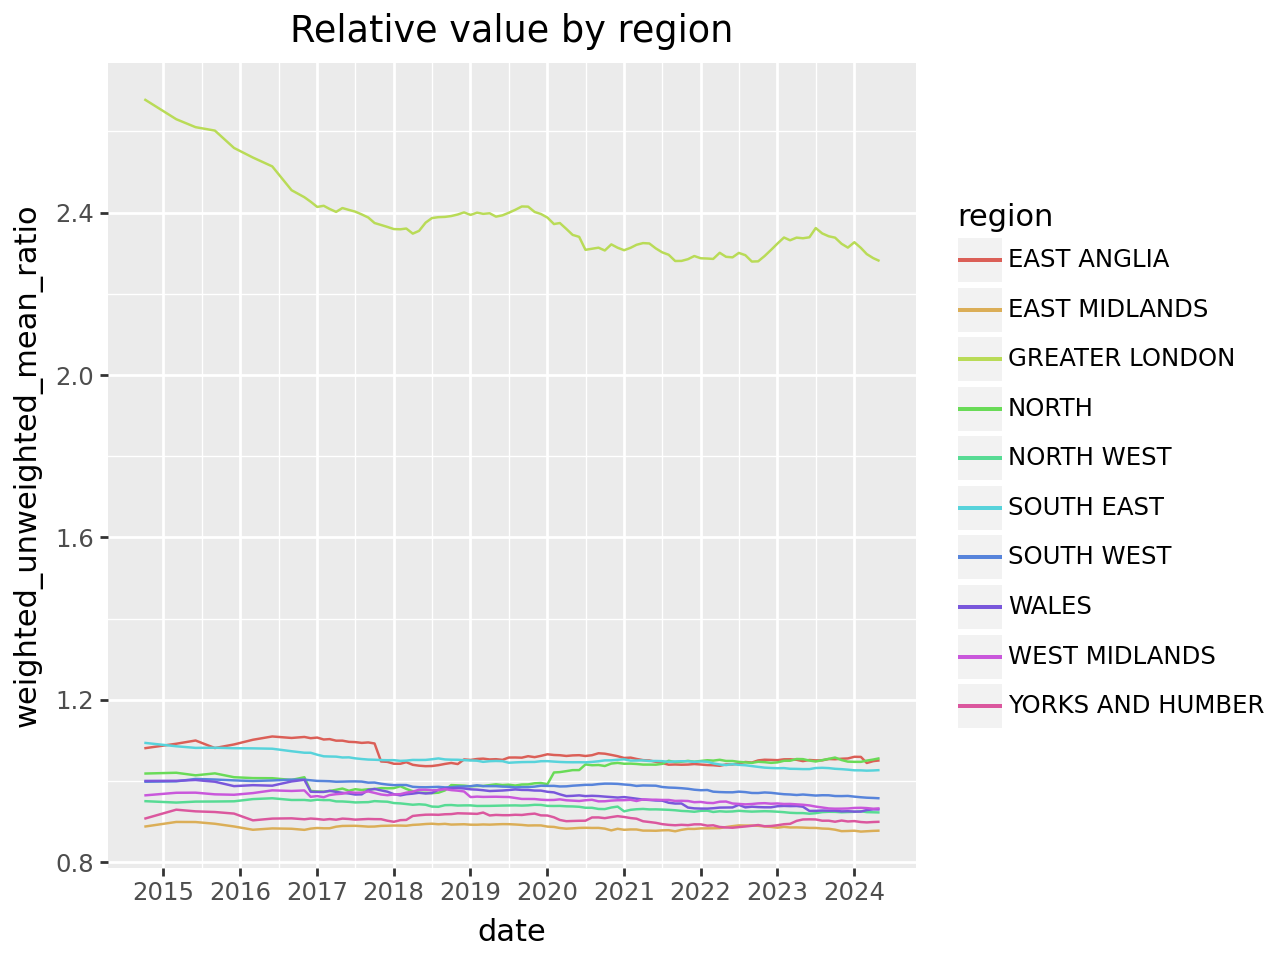

In [9]:
p = ggplot(df_msoa_region, aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'region')) + geom_line() + labs(
    title = "Relative value by region") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )


p.save(filename = '../figures/relative_value_region.png')

p

In [59]:
df_msoa_nested = create_time_series_by_groups(msoa_dwellings = msoa_dwelling, grouping_vars= ['nested_title'])

100%|██████████| 99/99 [00:25<00:00,  3.89it/s]


In [66]:
df_msoa_nested

,date,year,month,ocod_mean,ocod_median,dwelling_mean,dwelling_median,ocod_ratio_mean,ocod_total_counts,total_dwelling_count,total_value_ocod_mean,total_value_dwelling_mean,fraction_of_total_value,nested_title
0,2015-10-01,2015,10,802069,584312,259349,225859,3.092626,59386,20956408,47631714564,5435025639300,0.008764,False
1,2015-10-01,2015,10,833021,605354,321462,268585,2.591348,20838,6444078,17358512402,2071531738221,0.008380,True
2,2016-03-01,2016,3,832353,610137,267547,233604,3.111050,58741,20745363,48893254227,5550367259878,0.008809,False
3,2016-03-01,2016,3,838472,617114,330463,277294,2.537265,21760,6619110,18245157194,2187370952849,0.008341,True
4,2016-06-01,2016,6,845337,623067,272245,238080,3.105056,58704,20671606,49624720003,5627755182941,0.008818,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2025-03-01,2025,3,951277,672274,452731,383084,2.101197,22400,6925014,21308613345,3135169239577,0.006797,True
194,2025-04-01,2025,4,1010574,714206,394919,347389,2.558942,52445,19141555,52999605383,7559364582734,0.007011,False
195,2025-04-01,2025,4,944018,667680,452342,383012,2.086954,22373,6946529,21120522673,3142211706545,0.006722,True
196,2025-05-01,2025,5,1008623,714901,395173,347733,2.552358,52405,19122597,52856917750,7556739795774,0.006995,False


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_nested.png


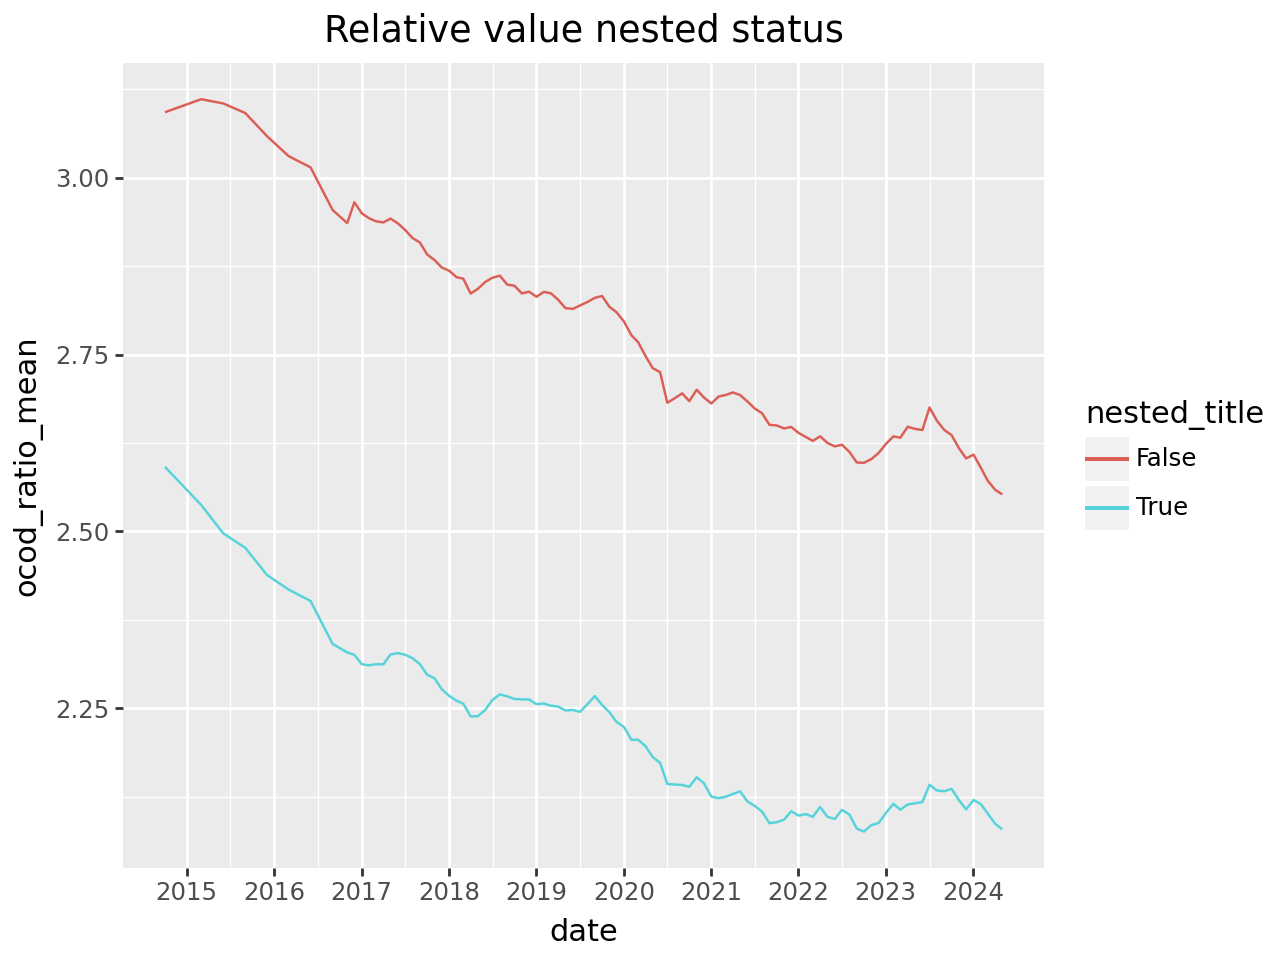

In [62]:
p = ggplot(df_msoa_nested, aes(x = 'date', y = 'ocod_ratio_mean', color = 'nested_title')) + geom_line() + labs(
    title = "Relative value nested status") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = '../figures/relative_value_nested.png')

p

In [68]:
df_msoa_nested

,date,year,month,ocod_mean,ocod_median,dwelling_mean,dwelling_median,ocod_ratio_mean,ocod_total_counts,total_dwelling_count,total_value_ocod_mean,total_value_dwelling_mean,fraction_of_total_value,nested_title
0,2015-10-01,2015,10,802069,584312,259349,225859,3.092626,59386,20956408,47631714564,5435025639300,0.008764,False
1,2015-10-01,2015,10,833021,605354,321462,268585,2.591348,20838,6444078,17358512402,2071531738221,0.008380,True
2,2016-03-01,2016,3,832353,610137,267547,233604,3.111050,58741,20745363,48893254227,5550367259878,0.008809,False
3,2016-03-01,2016,3,838472,617114,330463,277294,2.537265,21760,6619110,18245157194,2187370952849,0.008341,True
4,2016-06-01,2016,6,845337,623067,272245,238080,3.105056,58704,20671606,49624720003,5627755182941,0.008818,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2025-03-01,2025,3,951277,672274,452731,383084,2.101197,22400,6925014,21308613345,3135169239577,0.006797,True
194,2025-04-01,2025,4,1010574,714206,394919,347389,2.558942,52445,19141555,52999605383,7559364582734,0.007011,False
195,2025-04-01,2025,4,944018,667680,452342,383012,2.086954,22373,6946529,21120522673,3142211706545,0.006722,True
196,2025-05-01,2025,5,1008623,714901,395173,347733,2.552358,52405,19122597,52856917750,7556739795774,0.006995,False


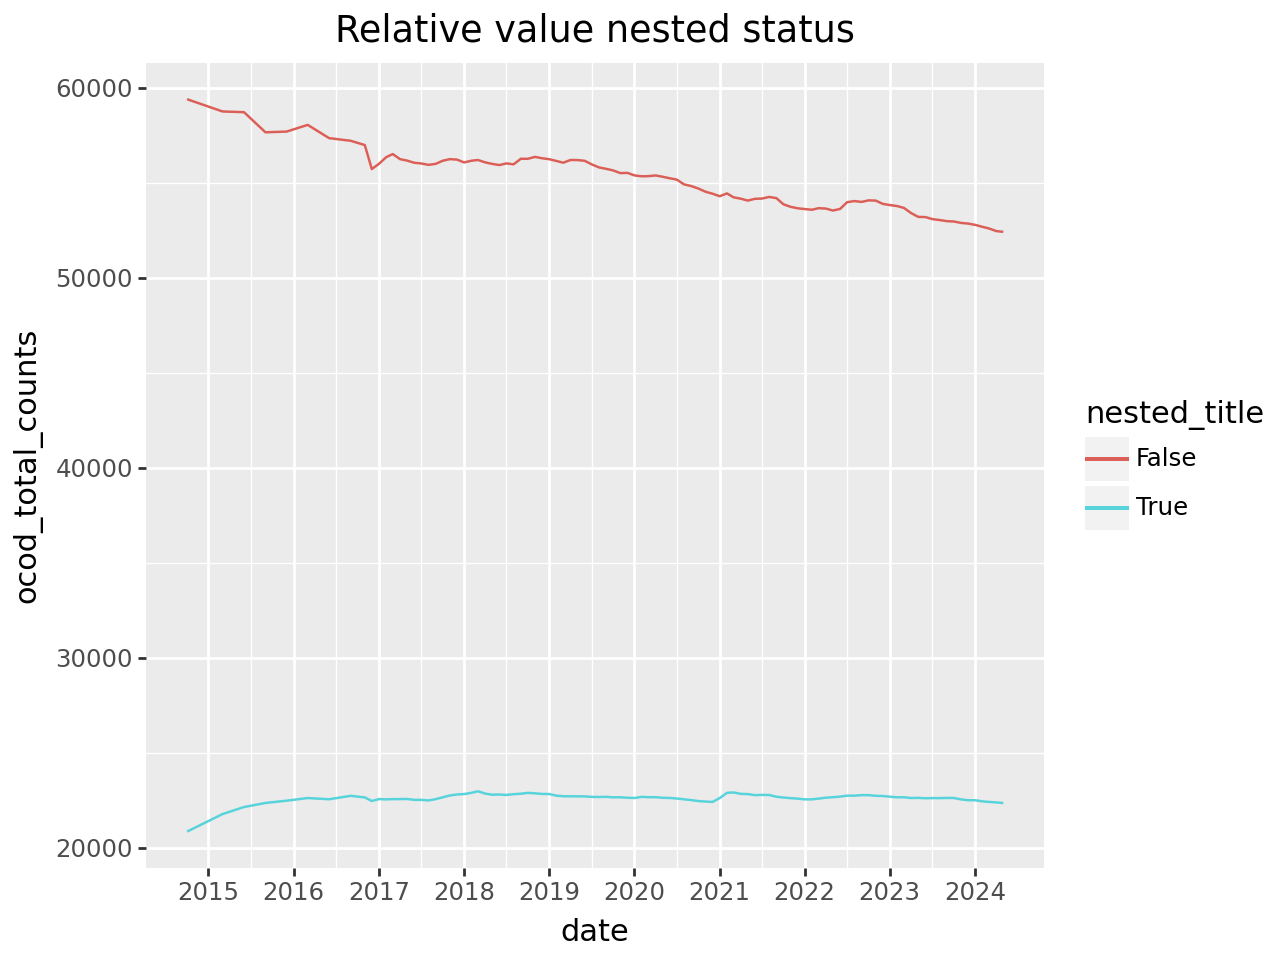

In [65]:
p = ggplot(df_msoa_nested, aes(x = 'date', y = 'ocod_total_counts', color = 'nested_title')) + geom_line() + labs(
    title = "Relative value nested status") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 )

p

## The total number of properties
 

In [12]:
df_msoa_nested.groupby('date')['total_counts'].sum()

date
2015-10-01    80224
2016-03-01    80501
2016-06-01    80835
2016-09-01    79990
2016-12-01    80148
              ...  
2025-01-01    75258
2025-02-01    75094
2025-03-01    74981
2025-04-01    74818
2025-05-01    74746
Name: total_counts, Length: 99, dtype: int64

# Country of Incorporation
 

In [13]:
df_msoa_incorporated = create_time_series_by_groups( ['country_incorporated'])

100%|██████████| 99/99 [00:37<00:00,  2.66it/s]


In [25]:
df_msoa_incorporated.to_csv('country.csv')

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_incorporation.png


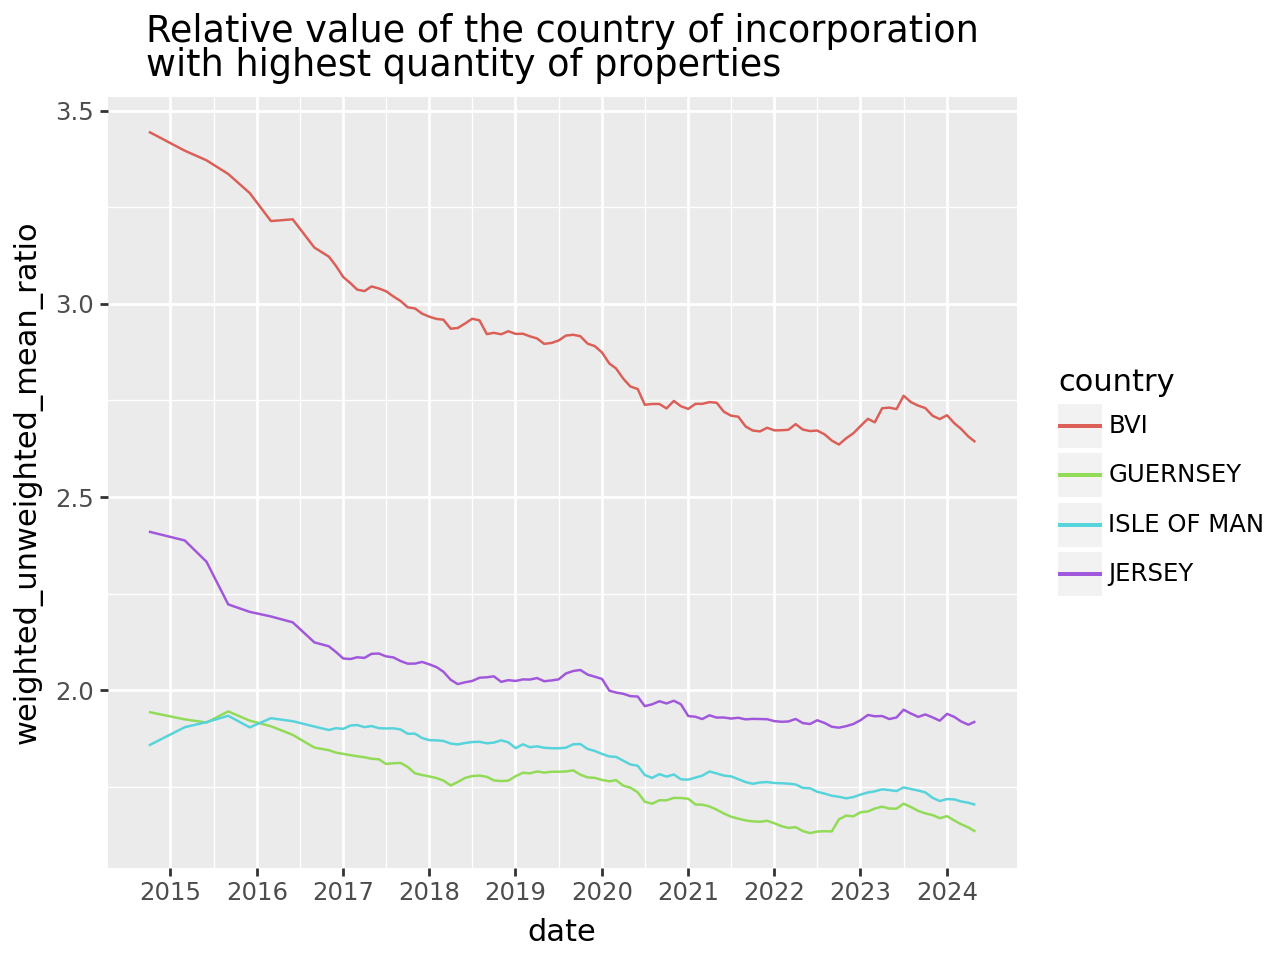

In [14]:
df_msoa_incorporated['country_incorporated'] = df_msoa_incorporated['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

p =  ggplot(df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin(['JERSEY', 'GUERNSEY', 
'ISLE OF MAN', 'BRITISH VIRGIN ISLANDS', 'BVI'])], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'country_incorporated')) + geom_line() + labs(
    title = "Relative value of the country of incorporation\nwith highest quantity of properties") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 ) + \
  guides(color = guide_legend(title = "country")) 

p.save(filename = '../figures/relative_value_incorporation.png')

p

In [15]:
df_msoa_incorporated

,date,year,month,ocod_weighted_mean,ocod_weighted_median,ocod_unweighted_mean,ocod_unweighted_median,weighted_unweighted_mean_ratio,weighted_unweighted_median_ratio,total_counts,total_value_mean,total_value_median,country_incorporated
0,2015-10-01,2015,10,122117,112500,122117,112500,1.000000,1.000000,4,488469,450000,00002065
1,2015-10-01,2015,10,111820,100000,111820,100000,1.000000,1.000000,1,111820,100000,0003280
2,2015-10-01,2015,10,161230,140000,161230,140000,1.000000,1.000000,1,161230,140000,085544C
3,2015-10-01,2015,10,434115,354300,434115,354300,1.000000,1.000000,2,868231,708600,1005646
4,2015-10-01,2015,10,516244,439975,516244,439975,1.000000,1.000000,1,516244,439975,1012258
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19612,2025-05-01,2025,5,511530,445185,516575,446199,0.990232,0.997727,8,4092240,3561480,"WASHINGTON, U.S.A."
19613,2025-05-01,2025,5,3213261,1501000,3213261,1501000,1.000000,1.000000,2,6426522,3002000,WESTERN SAMOA
19614,2025-05-01,2025,5,280000,237583,280000,237583,1.000000,1.000000,3,840000,712750,"WISCONSIN, U.S.A."
19615,2025-05-01,2025,5,1269905,893861,1175917,794500,1.079927,1.125061,18,22858299,16089500,"WYOMING, U.S.A."


In [16]:
df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin(['BVI', 'JERSEY', 'GUERNSEY', 'ISLO OF MAN']),
'total_counts':]

,total_counts,total_value_mean,total_value_median,country_incorporated
52,21052,24114955272,17092652191,BVI
88,10494,6449650071,4780219046,GUERNSEY
112,14671,9671866230,7206887775,JERSEY
268,21206,24684066037,17647309183,BVI
305,10788,6708633510,5045726332,GUERNSEY
...,...,...,...,...
19297,12292,8822687626,6701688169,GUERNSEY
19315,15440,12282698959,8973765760,JERSEY
19452,18390,24552579791,16767990180,BVI
19487,12240,8726226299,6645848116,GUERNSEY


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_incorporation_increases.png


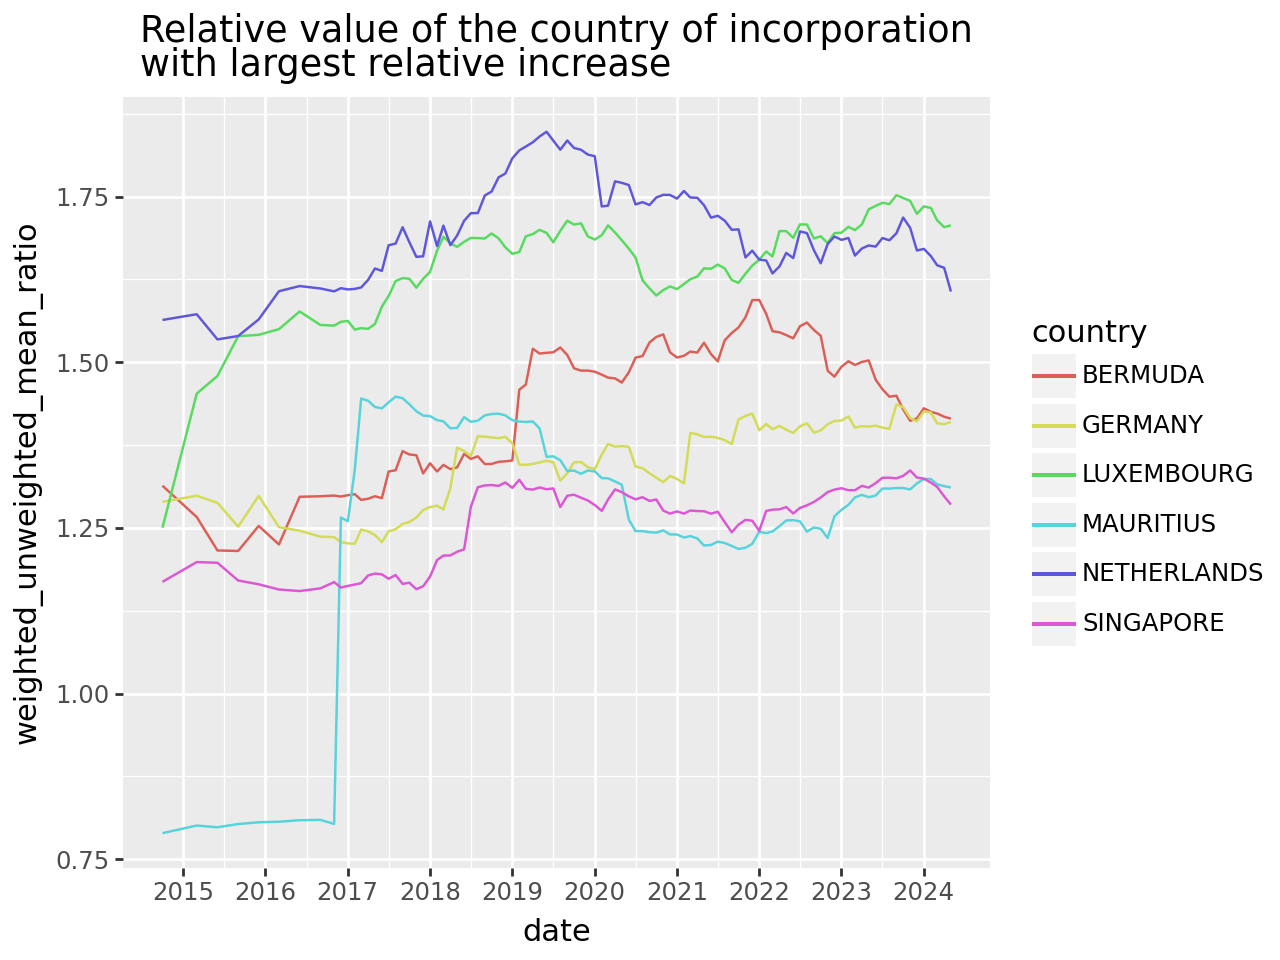

In [17]:
df_msoa_incorporated['country_incorporated'] = df_msoa_incorporated['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

p = ggplot(df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin([ 'LUXEMBOURG', 'MAURITIUS', 
'SINGAPORE', 'GERMANY', 'BERMUDA', 'NETHERLANDS'])], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', color = 'country_incorporated')) + geom_line() + labs(
    title = "Relative value of the country of incorporation\nwith largest relative increase") +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region['date'].min(), end=df_msoa_region['date'].max(), freq='YE'),
     date_labels='%Y'  # Format to show only year
 ) + \
  guides(color = guide_legend(title = "country")) 

p.save(filename = '../figures/relative_value_incorporation_increases.png')

p

In [18]:
countries = [
    "JERSEY",
    "BVI",
    "GUERNSEY",
    "ISLE OF MAN",
    "GIBRALTAR",
    "LUXEMBOURG",
    "SINGAPORE",
    "IRELAND",
    "HONG KONG",
    "PANAMA",
    "CAYMAN ISLANDS",
    "SEYCHELLES",
    "NETHERLANDS",
    "CYPRUS",
    "BAHAMAS",
    "MAURITIUS",
    "GERMANY",
    "AUSTRALIA",
    "BERMUDA",
    "DELAWARE, U.S.A."
]

In [19]:
df = df_msoa_incorporated.loc[df_msoa_incorporated['country_incorporated'].isin(countries)]

# Get values at min and max dates
grouped = df.groupby('country_incorporated').apply(
    lambda x: pd.Series({
        'min_date_value': x.loc[x['date'].idxmin(), 'weighted_unweighted_mean_ratio'],
        'max_date_value': x.loc[x['date'].idxmax(), 'weighted_unweighted_mean_ratio']
    })
)

# Calculate ratio of change
grouped['ratio_change'] = grouped['max_date_value'] / grouped['min_date_value']
result = grouped['ratio_change']

result.sort_values().reset_index()

/tmp/ipykernel_2252/3819271352.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,country_incorporated,ratio_change
0,AUSTRALIA,0.639478
1,BVI,0.766989
2,JERSEY,0.796234
3,CAYMAN ISLANDS,0.830600
4,GUERNSEY,0.840845
5,BAHAMAS,0.873460
6,SEYCHELLES,0.878846
7,HONG KONG,0.910346
8,PANAMA,0.916263
9,ISLE OF MAN,0.917338


In [20]:
df

,date,year,month,ocod_weighted_mean,ocod_weighted_median,ocod_unweighted_mean,ocod_unweighted_median,weighted_unweighted_mean_ratio,weighted_unweighted_median_ratio,total_counts,total_value_mean,total_value_median,country_incorporated
38,2015-10-01,2015,10,957090,680779,606322,455655,1.578516,1.494067,322,308183153,219210926,AUSTRALIA
40,2015-10-01,2015,10,1092434,778875,551529,430887,1.980736,1.807608,1190,1299997576,926861477,BAHAMAS
49,2015-10-01,2015,10,552631,418121,420709,327876,1.313571,1.275242,479,264710328,200280290,BERMUDA
52,2015-10-01,2015,10,1145494,811925,332477,282893,3.445335,2.870070,21052,24114955272,17092652191,BVI
57,2015-10-01,2015,10,888002,636009,442248,344353,2.007928,1.846966,1102,978579047,700881997,CAYMAN ISLANDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19527,2025-05-01,2025,5,1006787,727208,767917,585257,1.311062,1.242545,400,402715102,290883596,MAURITIUS
19534,2025-05-01,2025,5,1091062,773259,679107,529623,1.606613,1.460019,481,524801204,371938038,NETHERLANDS
19555,2025-05-01,2025,5,2022104,1259178,833836,625064,2.425062,2.014477,1124,2272845769,1415316766,PANAMA
19571,2025-05-01,2025,5,725950,560715,576920,472886,1.258320,1.185728,1230,892919674,689679533,SEYCHELLES


In [21]:

df_msoa_region_nested = create_time_series_by_groups( ['region', 'nested_title'])

100%|██████████| 99/99 [00:30<00:00,  3.23it/s]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/relative_value_nested_region.png


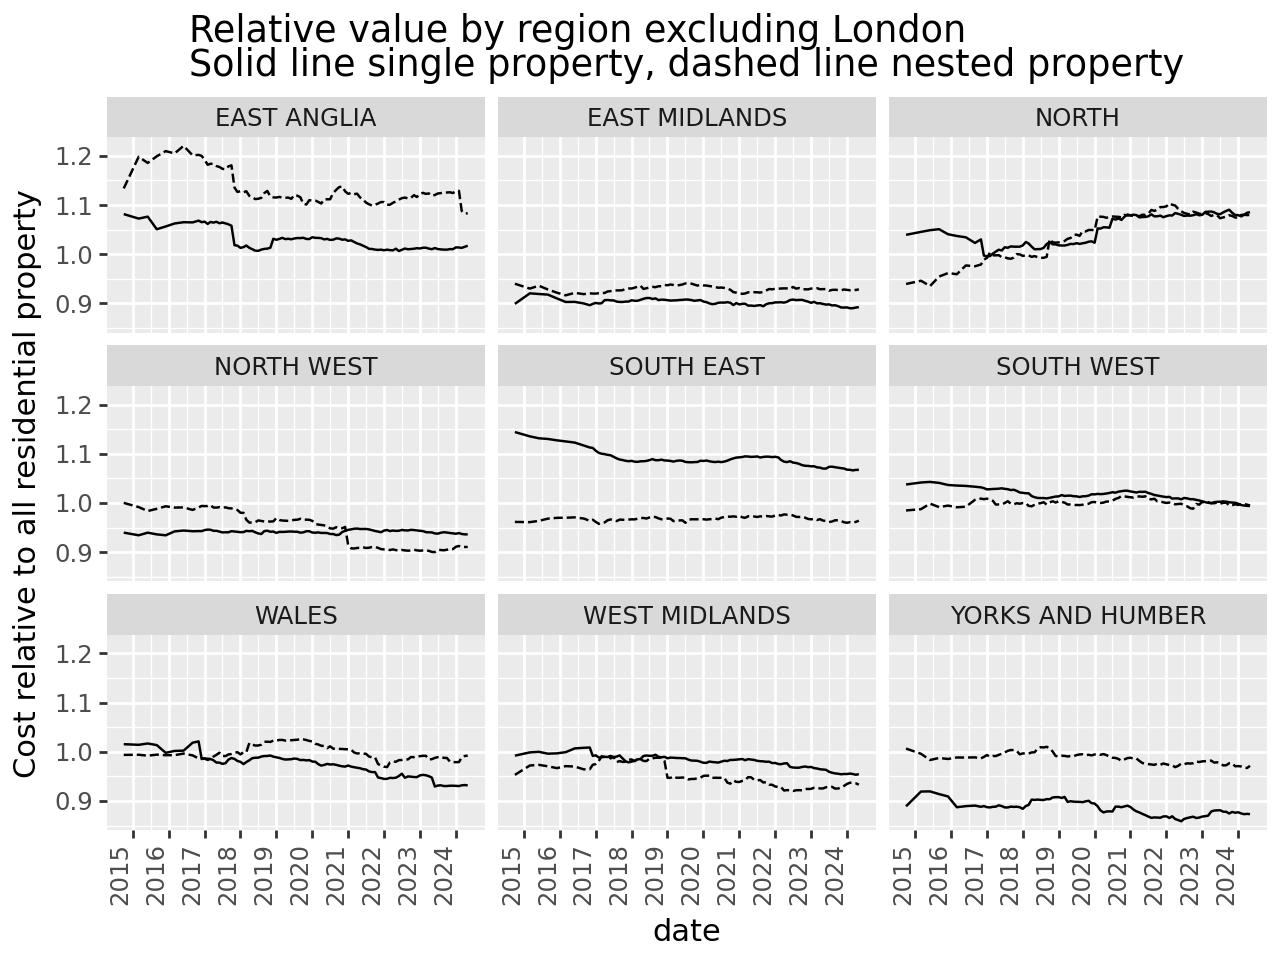

In [22]:
p = ggplot(df_msoa_region_nested.loc[df_msoa_region_nested['region']!='GREATER LONDON'], 
aes(x = 'date', y = 'weighted_unweighted_mean_ratio', linetype = 'nested_title')) + geom_line() + labs(
    title = "Relative value by region excluding London\nSolid line single property, dashed line nested property",
    linetype = 'nested',
    y = 'Cost relative to all residential property') +   scale_x_date(
     breaks=pd.date_range(start=df_msoa_region_nested['date'].min(), end=df_msoa_region_nested['date'].max(), freq='YE'),
     date_labels='%Y'
 ) + facet_wrap("region") +\
    theme(
        axis_text_x=element_text(angle=90,hjust = 1),
        legend_position = 'none'
    )


p.save(filename = figures_folder / 'relative_value_nested_region.png')

p

In [3]:
df_msoa_lad = create_time_series_by_groups( ['lad11cd'])


100%|██████████| 99/99 [00:32<00:00,  3.07it/s]


In [6]:
df_msoa_lad

,date,year,month,ocod_weighted_mean,ocod_weighted_median,ocod_unweighted_mean,ocod_unweighted_median,weighted_unweighted_mean_ratio,weighted_unweighted_median_ratio,total_counts,total_value_mean,total_value_median,lad11cd
0,2015-10-01,2015,10,85808,75346,102161,94184,0.839931,0.799990,36,3089107,2712475,E06000001
1,2015-10-01,2015,10,86316,76982,110463,99959,0.781407,0.770140,83,7164299,6389550,E06000002
2,2015-10-01,2015,10,107756,96375,117244,104807,0.919074,0.919547,38,4094756,3662267,E06000003
3,2015-10-01,2015,10,150381,138366,129757,120217,1.158943,1.150973,62,9323638,8578747,E06000004
4,2015-10-01,2015,10,118703,110795,124006,114807,0.957235,0.965053,22,2611473,2437500,E06000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31477,2025-05-01,2025,5,229310,205937,196377,176875,1.167701,1.164311,8,1834482,1647500,W06000020
31478,2025-05-01,2025,5,368560,336144,374078,340298,0.985250,0.987795,17,6265532,5714460,W06000021
31479,2025-05-01,2025,5,236459,218117,226677,209781,1.043154,1.039736,47,11113597,10251500,W06000022
31480,2025-05-01,2025,5,260960,238645,271143,245625,0.962445,0.971586,12,3131528,2863750,W06000023


In [8]:
df_msoa_lad['fraction'] = df_msoa_lad.groupby('date')['total_value_mean'].transform(lambda x: x / x.sum())

In [11]:
df_msoa_lad.groupby('lad11cd')[['fraction', 'total_value_mean']].mean().sort_values('fraction')

,fraction,total_value_mean
lad11cd,,
E07000136,0.000014,9.848934e+05
E06000053,0.000014,1.015548e+06
W06000019,0.000016,1.147755e+06
W06000024,0.000016,1.156881e+06
W06000020,0.000022,1.565239e+06
...,...,...
E09000013,0.019611,1.420076e+09
E09000032,0.022521,1.636744e+09
E09000007,0.043378,3.147165e+09


In [28]:
df_msoa_lad.to_csv('../data/lad.csv')